In [1]:
!pip install pandas folium

In [27]:
from IPython.display import display, HTML
import pandas as pd
pd.options.mode.chained_assignment = None 
import sqlite3
from sqlite3 import Error
import time
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from folium import Map
from folium.plugins import HeatMap

def create_connection(db_file, delete_db=False):
    import os
    if delete_db and os.path.exists(db_file):
        os.remove(db_file)

    conn = None
    try:
        conn = sqlite3.connect(db_file)
        conn.execute("PRAGMA foreign_keys = 1")
    except Error as e:
        print(e)

    return conn


def create_table(conn, create_table_sql, drop_table_name=None):
    
    if drop_table_name: # You can optionally pass drop_table_name to drop the table. 
        try:
            c = conn.cursor()
            c.execute("""DROP TABLE IF EXISTS %s""" % (drop_table_name))
        except Error as e:
            print(e)
    
    try:
        c = conn.cursor()
        c.execute(create_table_sql)
    except Error as e:
        print(e)
        
def execute_sql_statement(sql_statement, conn):
    cur = conn.cursor()
    cur.execute(sql_statement)

    rows = cur.fetchall()

    return rows

In [3]:
# Create DB file

normalized_db = 'lightning_fire_normalized.db'
conn = create_connection(normalized_db, delete_db=True)

In [4]:
df = pd.read_csv("US_Lightning_Forest_Fires.csv")
df.head()

,Unnamed: 0,index,FIRE_YEAR,Fire_Date,DISCOVERY_TIME,STAT_CAUSE_DESCR,Days_to_extinguish_fire,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE,FIPS_CODE,FIPS_NAME
0,0,1,2004,05-12-2004,845.0,Lightning,0.0,1530.0,0.25,A,38.933056,-120.404444,CA,61.0,Placer
1,1,3,2004,06-28-2004,1600.0,Lightning,5.0,1400.0,0.10,A,38.559167,-119.913333,CA,3.0,Alpine
2,2,4,2004,06-28-2004,1600.0,Lightning,5.0,1200.0,0.10,A,38.559167,-119.933056,CA,3.0,Alpine
3,3,5,2004,06-30-2004,1800.0,Lightning,1.0,1600.0,0.10,A,38.635278,-120.103611,CA,5.0,Amador
4,4,6,2004,07-01-2004,1800.0,Lightning,1.0,1400.0,0.10,A,38.688333,-120.153333,CA,17.0,El Dorado


In [5]:
df = df.drop(['index', 'STAT_CAUSE_DESCR', 'FIPS_CODE', 'FIPS_NAME'], axis=1)
df1 = df.iloc[: , 1:]
df1 = df1.dropna()
df1.head()

,FIRE_YEAR,Fire_Date,DISCOVERY_TIME,Days_to_extinguish_fire,CONT_TIME,FIRE_SIZE,FIRE_SIZE_CLASS,LATITUDE,LONGITUDE,STATE
0,2004,05-12-2004,845.0,0.0,1530.0,0.25,A,38.933056,-120.404444,CA
1,2004,06-28-2004,1600.0,5.0,1400.0,0.10,A,38.559167,-119.913333,CA
2,2004,06-28-2004,1600.0,5.0,1200.0,0.10,A,38.559167,-119.933056,CA
3,2004,06-30-2004,1800.0,1.0,1600.0,0.10,A,38.635278,-120.103611,CA
4,2004,07-01-2004,1800.0,1.0,1400.0,0.10,A,38.688333,-120.153333,CA


In [6]:
print(df1.shape)

(219593, 10)


In [7]:
df1.to_csv(path_or_buf="cleaned_data_lightning.csv")

In [8]:
header = []
for h in df1:
    header.append(h)
    
#print(columns)

In [9]:
# Create FireDate Table

create_region_sql = """CREATE TABLE IF NOT EXISTS[FireDate](
                        [FireDateID] INTEGER NOT NULL PRIMARY KEY,
                        [FireDate] TEXT NOT NULL)"""
create_table(conn, create_region_sql)
fire_date = []
for val in df1['Fire_Date']:
    if val not in fire_date:
        fire_date.append(val) 

fire_date.sort(key=lambda x: time.mktime(time.strptime(x,"%m-%d-%Y")))

fire_date_insert_vals = [(i+1, fire_date[i]) for i in range(len(fire_date))]
print(fire_date_insert_vals)

def insert_firedate(conn, values):
    sql = '''INSERT OR IGNORE INTO FireDate(FireDateID, FireDate)
        VALUES(?, ?)'''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()
    return cur.lastrowid

insert_firedate(conn, fire_date_insert_vals)

[(1, '01-01-1992'), (2, '01-11-1992'), (3, '01-25-1992'), (4, '02-04-1992'), (5, '02-19-1992'), (6, '02-21-1992'), (7, '02-23-1992'), (8, '02-29-1992'), (9, '03-01-1992'), (10, '03-08-1992'), (11, '03-09-1992'), (12, '03-13-1992'), (13, '03-19-1992'), (14, '03-21-1992'), (15, '03-22-1992'), (16, '03-23-1992'), (17, '03-24-1992'), (18, '03-25-1992'), (19, '03-26-1992'), (20, '03-27-1992'), (21, '03-28-1992'), (22, '03-29-1992'), (23, '03-30-1992'), (24, '03-31-1992'), (25, '04-01-1992'), (26, '04-02-1992'), (27, '04-04-1992'), (28, '04-05-1992'), (29, '04-08-1992'), (30, '04-10-1992'), (31, '04-11-1992'), (32, '04-12-1992'), (33, '04-13-1992'), (34, '04-14-1992'), (35, '04-15-1992'), (36, '04-16-1992'), (37, '04-17-1992'), (38, '04-21-1992'), (39, '04-22-1992'), (40, '04-23-1992'), (41, '04-24-1992'), (42, '04-25-1992'), (43, '04-26-1992'), (44, '04-27-1992'), (45, '04-28-1992'), (46, '04-29-1992'), (47, '04-30-1992'), (48, '05-01-1992'), (49, '05-02-1992'), (50, '05-03-1992'), (51, '05

In [10]:
date = pd.read_sql_query("""SELECT * FROM FireDate""", conn)
date

,FireDateID,FireDate
0,1,01-01-1992
1,2,01-11-1992
2,3,01-25-1992
3,4,02-04-1992
4,5,02-19-1992
...,...,...
5981,5982,12-06-2015
5982,5983,12-08-2015
5983,5984,12-09-2015
5984,5985,12-11-2015


In [11]:
# Create fire_date dict

fire_date = {fire_date_insert_vals[i][1]: fire_date_insert_vals[i][0] for i in range(len(fire_date_insert_vals))}

In [12]:
print(fire_date)

{'01-01-1992': 1, '01-11-1992': 2, '01-25-1992': 3, '02-04-1992': 4, '02-19-1992': 5, '02-21-1992': 6, '02-23-1992': 7, '02-29-1992': 8, '03-01-1992': 9, '03-08-1992': 10, '03-09-1992': 11, '03-13-1992': 12, '03-19-1992': 13, '03-21-1992': 14, '03-22-1992': 15, '03-23-1992': 16, '03-24-1992': 17, '03-25-1992': 18, '03-26-1992': 19, '03-27-1992': 20, '03-28-1992': 21, '03-29-1992': 22, '03-30-1992': 23, '03-31-1992': 24, '04-01-1992': 25, '04-02-1992': 26, '04-04-1992': 27, '04-05-1992': 28, '04-08-1992': 29, '04-10-1992': 30, '04-11-1992': 31, '04-12-1992': 32, '04-13-1992': 33, '04-14-1992': 34, '04-15-1992': 35, '04-16-1992': 36, '04-17-1992': 37, '04-21-1992': 38, '04-22-1992': 39, '04-23-1992': 40, '04-24-1992': 41, '04-25-1992': 42, '04-26-1992': 43, '04-27-1992': 44, '04-28-1992': 45, '04-29-1992': 46, '04-30-1992': 47, '05-01-1992': 48, '05-02-1992': 49, '05-03-1992': 50, '05-04-1992': 51, '05-05-1992': 52, '05-06-1992': 53, '05-07-1992': 54, '05-08-1992': 55, '05-09-1992': 56, 

In [13]:
# Create FireState Table

create_firestate_sql = """CREATE TABLE IF NOT EXISTS[FireState](
                        [StateID] INTEGER NOT NULL PRIMARY KEY,
                        [State] TEXT NOT NULL)"""
create_table(conn, create_firestate_sql)

fire_state = []
for val in df1['STATE']:
    if val not in fire_state:
        fire_state.append(val)

fire_state.sort()
#print(fire_state)

fire_state_insert_vals = [(i+1, fire_state[i]) for i in range(len(fire_state))]

def insert_firestate(conn, values):
    sql = '''INSERT OR IGNORE INTO FireState(StateID, State)
        VALUES(?, ?)'''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()
    return cur.lastrowid

insert_firestate(conn, fire_state_insert_vals)

print(fire_state_insert_vals)

[(1, 'AK'), (2, 'AL'), (3, 'AR'), (4, 'AZ'), (5, 'CA'), (6, 'CO'), (7, 'DC'), (8, 'FL'), (9, 'GA'), (10, 'HI'), (11, 'IA'), (12, 'ID'), (13, 'IL'), (14, 'IN'), (15, 'KS'), (16, 'KY'), (17, 'LA'), (18, 'MA'), (19, 'MD'), (20, 'ME'), (21, 'MI'), (22, 'MN'), (23, 'MO'), (24, 'MS'), (25, 'MT'), (26, 'NC'), (27, 'ND'), (28, 'NE'), (29, 'NH'), (30, 'NJ'), (31, 'NM'), (32, 'NV'), (33, 'NY'), (34, 'OH'), (35, 'OK'), (36, 'OR'), (37, 'PA'), (38, 'PR'), (39, 'SC'), (40, 'SD'), (41, 'TN'), (42, 'TX'), (43, 'UT'), (44, 'VA'), (45, 'VT'), (46, 'WA'), (47, 'WI'), (48, 'WV'), (49, 'WY')]


In [16]:
# Create FireDetails Table
create_details_sql = """CREATE TABLE IF NOT EXISTS[FireDetails](
                        [FireDetailsID] INTEGER NOT NULL PRIMARY KEY,
                        [FireDateID] INTEGER NOT NULL,
                        [DiscoveryTime] INTEGER NOT NULL,
                        [DaysToExt] INTEGER NOT NULL,
                        [ContTime] INTEGER NOT NULL,
                        [FireSize] REAL NOT NULL,
                        [FireClass] TEXT NOT NULL,
                        [Lattitude] TEXT NOT NULL,
                        [Longitude] TEXT NOT NULL,
                        [StateID] INTEGER NOT NULL,
                        FOREIGN KEY(FireDateID) REFERENCES FireDate(FireDateID),
                        FOREIGN KEY(StateID) REFERENCES FireState(StateID))"""
#import pdb
#pdb.set_trace()
create_table(conn, create_details_sql)

fire_details = []
with open("cleaned_data_lightning.csv", 'r') as db_file:
    for index, line in enumerate(db_file):
        if not line.strip() or index == 0:
            continue

        columns = line.split(',')
        days_to_ext = int(columns[4].split('.')[0])
        cont_time = int(columns[5].split('.')[0])
        fire_size = float(columns[6])
        fire_details.append((index, fire_date[columns[2]], int(columns[3].split('.')[0]), 
                             days_to_ext, cont_time, fire_size, columns[7], columns[8], columns[9],
                             fire_state[columns[10].rstrip()] ))

        
#fire_details = sorted(fire_details, key=lambda a : a[0] + ' ' + a[1])
fire_state_vals = []
for i in fire_details:
    fire_state_vals.append(i[9])
    

def unique(list1):
 
    # initialize a null list
    unique_list = []
     
    # traverse for all elements
    for x in list1:
        # check if exists in unique_list or not
        if x not in unique_list:
            unique_list.append(x)
    # print list
    for x in unique_list:
        print(x)
        
    return unique_list

#fire_uni = unique(fire_state_vals)

def insert_firedet(conn, values):
    sql = ''' INSERT OR IGNORE INTO FireDetails(FireDetailsID, FireDateID, DiscoveryTime, DaysToExt,
            ContTime, FireSize, FireClass, Lattitude, Longitude, StateID)
              VALUES(?, ?, ?, ?, ?, ?, ?, ?, ?, ?) '''
    cur = conn.cursor()
    cur.executemany(sql, values)
    conn.commit()
    return cur.lastrowid

insert_firedet(conn, fire_details)

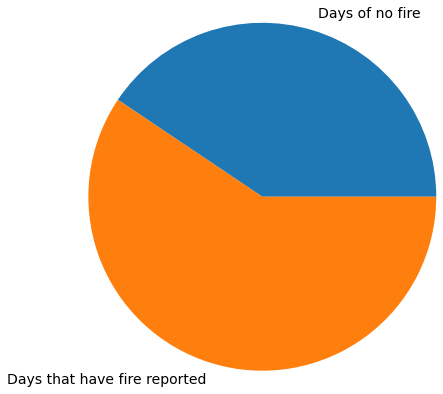

In [38]:
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
cur = conn.cursor()
cur.execute("""select count(FireDateID) AS fire_count
                   from FireDate""")
rows = cur.fetchall()
fire_count = rows[0][0]

cur = conn.cursor()

cur.execute("""SELECT FireDate FROM FireDate ORDER BY FireDateID ASC LIMIT 1;""")
rows = cur.fetchall()
first_fire_date = rows[0][0]
cur.execute("""SELECT FireDate FROM FireDate ORDER BY FireDateID DESC LIMIT 1;""")
rows = cur.fetchall()
last_fire_date = rows[0][0]


from datetime import datetime
# Do last - first to get no of days
def days_between(d1, d2):
    d1 = datetime.strptime(d1, "%m-%d-%Y")
    d2 = datetime.strptime(d2, "%m-%d-%Y")
    return abs((d2 - d1).days)

total_days = days_between(first_fire_date, last_fire_date)

y = np.array([fire_count,total_days])
mylabels = ["Days of no fire", "Days that have fire reported"]

plt.pie(y, labels = mylabels, radius = 2, textprops={'fontsize': 14})
plt.show()


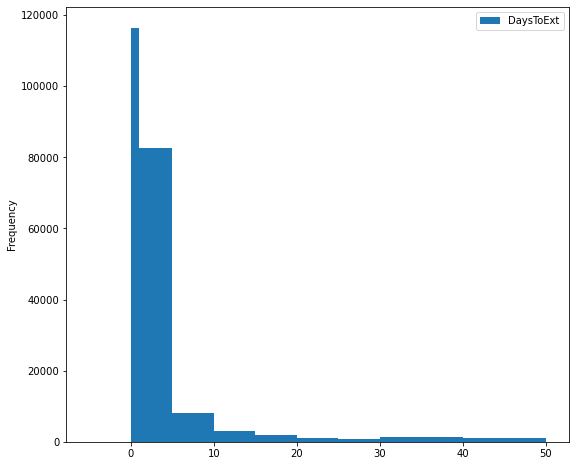

In [102]:
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
sql_statement = pd.read_sql_query("""select DaysToExt, ContTime from FireDetails""",conn)
cur = conn.cursor()

#sns.histplot(data=sql_statement, x="DaysToExt",bins=100, figsize=(10,10))
# plt.figure(figsize=(50, 60))
# plt.show()

bins_list = [-5,-1,0,1,5,10, 15, 20, 25, 30, 40, 50]
df.plot.hist(y='DaysToExt', bins = bins_list, figsize=(9,8),)
# # plt.title('matplotlib.pyplot.hist() function\n\n',
#           fontweight ="bold")
plt.show()

# fig, ax = plt.subplots(figsize = (20,15))
# new_df = state_f.sort_values(by = 'FireSize',ascending=False)
# sns.barplot(x = 'State',y = 'FireSize',ax = ax,data = new_df)

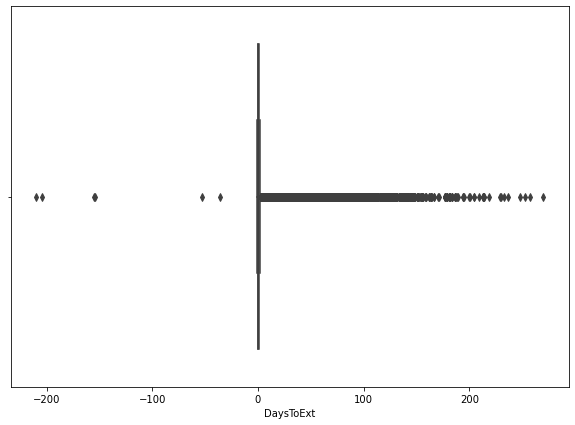

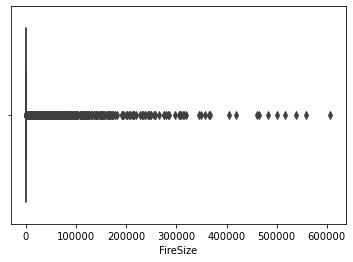

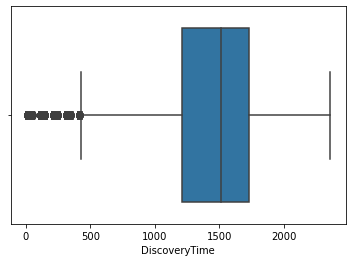

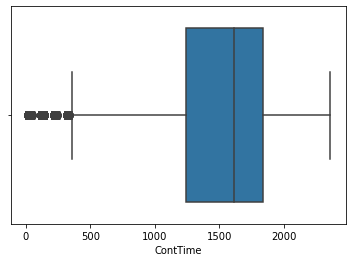

In [25]:
############ Boxplot of relevent columns ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
state = pd.read_sql_query("""SELECT * FROM FireDetails""", conn)
fig = plt.figure(figsize =(10, 7))
cont_train = state[['DaysToExt','FireSize','DiscoveryTime','ContTime']]
for i in cont_train:
    sns.boxplot(cont_train[i])
    plt.show()


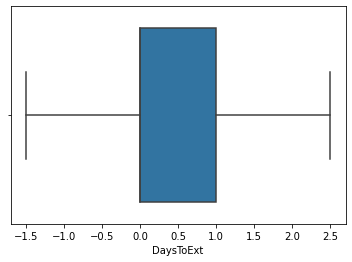

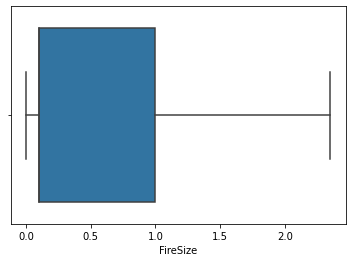

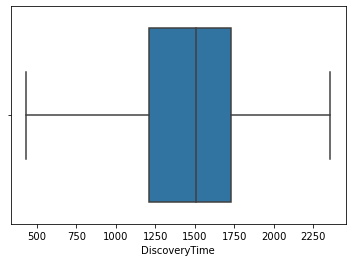

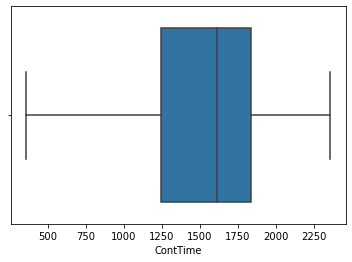

In [28]:
################ Removing outliers ###################
def remove_outlier(col):
    sorted(col)
    Q1,Q3=np.percentile(col,[25,75])
    IQR=Q3-Q1
    lower_range= Q1-(1.5 * IQR)
    upper_range= Q3+(1.5 * IQR)
    return lower_range, upper_range
for column in cont_train.columns:
    lr,ur=remove_outlier(cont_train[column])
    cont_train[column]=np.where(cont_train[column]>ur,ur,cont_train[column])
    cont_train[column]=np.where(cont_train[column]<lr,lr,cont_train[column])
for i in cont_train:
    sns.boxplot(cont_train[i])
    plt.show()


<AxesSubplot:xlabel='State', ylabel='FireSize'>

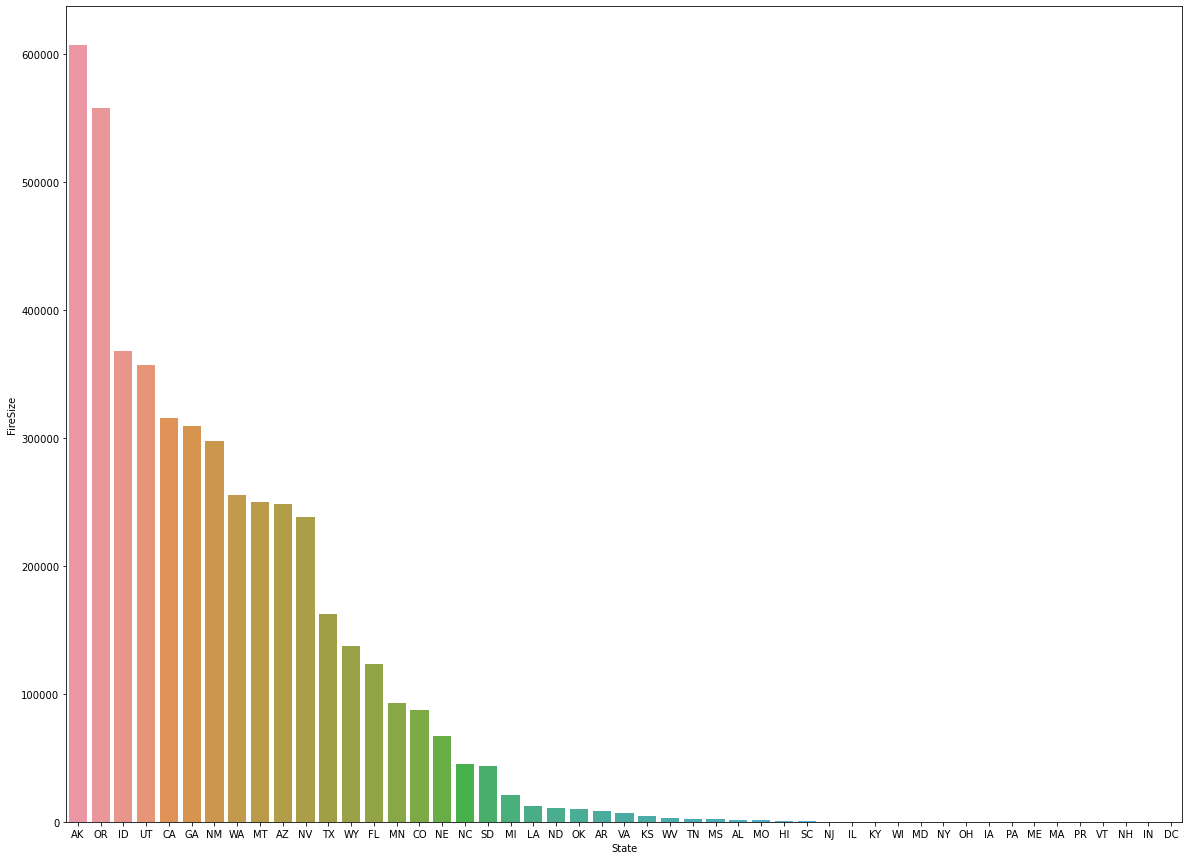

In [30]:
###########Barplot for Highest frequency of fire by state############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
state_f = pd.read_sql_query("""SELECT a.State, a.fs FireSize
from 
((select StateID, max(FireSize) as fs
from FireDetails 
group by StateID ) x
INNER join 
(SELECT State,StateID 
FROM FireState ) y
on x.StateID= y.StateID) a""", conn)

# fig = plt.figure(figsize =(10, 7))
cur = conn.cursor()
fig, ax = plt.subplots(figsize = (20,15))
new_df = state_f.sort_values(by = 'FireSize',ascending=False)
sns.barplot(x = 'State',y = 'FireSize',ax = ax,data = new_df)

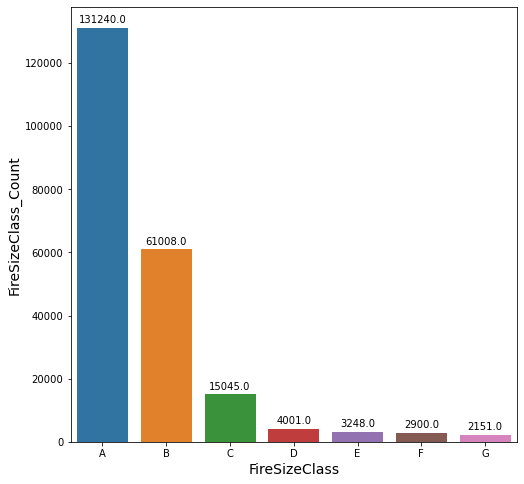

In [31]:
###########Barplot for frequency A B C D E F G ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
fireclass_f = pd.read_sql_query("""SELECT FireClass, count(FireClass) as FireClass_Count 
from FireDetails
group by FireClass""", conn)

# fig = plt.figure(figsize =(10, 7))
cur = conn.cursor()
# fig, ax = plt.subplots(figsize = (20,15))
new_df = fireclass_f.sort_values(by = 'FireClass_Count',ascending=False)
# sns.barplot(x = 'FireClass',y = 'FireClass_Count',ax = ax,data = new_df)
plt.figure(figsize=(8, 8))
 
# Defining the values for x-axis, y-axis
plots = sns.barplot(x="FireClass", y="FireClass_Count", data=new_df)
 
# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
 
# Setting the label for x-axis
plt.xlabel("FireSizeClass", size=14)
 
# Setting the label for y-axis
plt.ylabel("FireSizeClass_Count", size=14)
 
# Finally showing the plot
plt.show()

In [32]:
########### Hotspot for frequency ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
hotspot_f = pd.read_sql_query("""SELECT  FireSize, Longitude, Lattitude
from FireDetails 
order by FireSize DESC 
LIMIT 15""", conn)
cur = conn.cursor()
data_map = Map(location=[57, -138], zoom_start=3.4, )
hm_wide = HeatMap(
    list(zip(hotspot_f.Lattitude.values, hotspot_f.Longitude.values)),
    min_opacity=0.2,
    radius=17, 
    blur=1,
    max_zoom=1,
)
data_map.add_child(hm_wide)

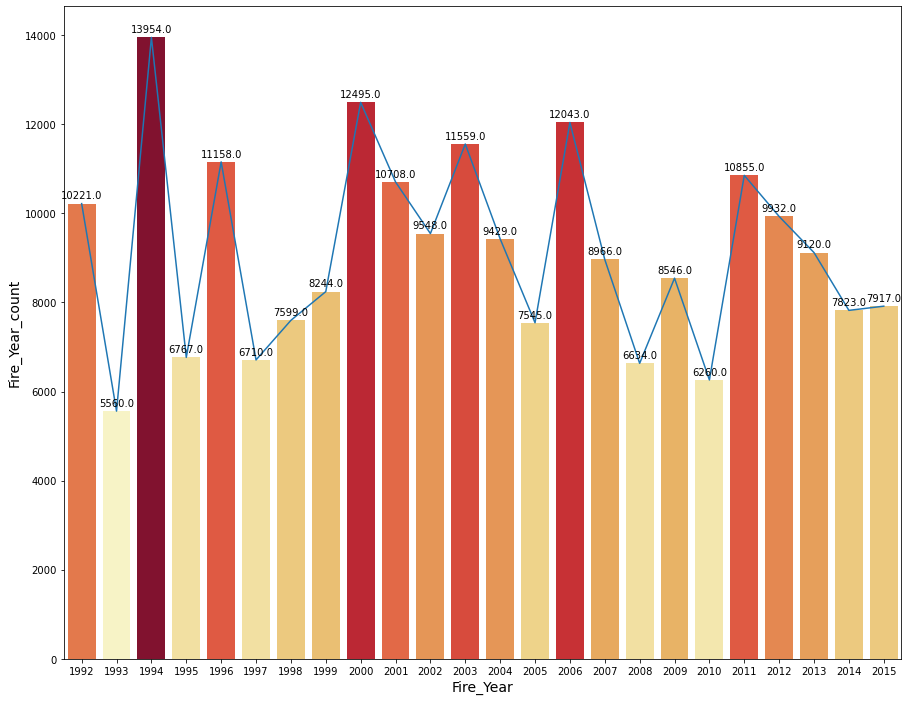

In [33]:
########### Count of fire across years ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
fire_y = pd.read_sql_query("""
SELECT  Fire_Year, count(Fire_Year) as Fire_Year_count
FROM 
(SELECT fd2.FireSize, fd2.DaysToExt, fd2.FireClass, fd1.Fire_Year FROM
((SELECT  FireDateID, substr(FireDate, 7, 10) as Fire_Year
From FireDate) fd1
JOIN 
(SELECT * from FireDetails) fd2
on fd1.FireDateID = fd2.FireDateID) fd3)fd4
group by Fire_Year""", conn)

new_df = fire_y.sort_values(by = 'Fire_Year',ascending=True)
plt.figure(figsize=(15, 12))
 
# Defining the values for x-axis, y-axis
def colors_from_values(values, palette_name):
    # normalize the values to range [0, 1]
    normalized = (values - min(values)) / (max(values) - min(values))
    # convert to indices
    indices = np.round(normalized * (len(values) - 1)).astype(np.int32)
    # use the indices to get the colors
    palette = sns.color_palette(palette_name, len(values))
    return np.array(palette).take(indices, axis=0)

# sns.set(style="whitegrid", color_codes=True)
plots = sns.lineplot(x="Fire_Year", y="Fire_Year_count", data=new_df)
plots = sns.barplot(x="Fire_Year", y="Fire_Year_count", data=new_df, palette=colors_from_values(new_df.Fire_Year_count.values, "YlOrRd"))


# Iterrating over the bars one-by-one
for bar in plots.patches:
    plots.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=10, xytext=(0, 8),
                   textcoords='offset points')
 
# Setting the label for x-axis
plt.xlabel("Fire_Year", size=14)
 
# Setting the label for y-axis
plt.ylabel("Fire_Year_count", size=14)
 
# Finally showing the plot
plt.show()

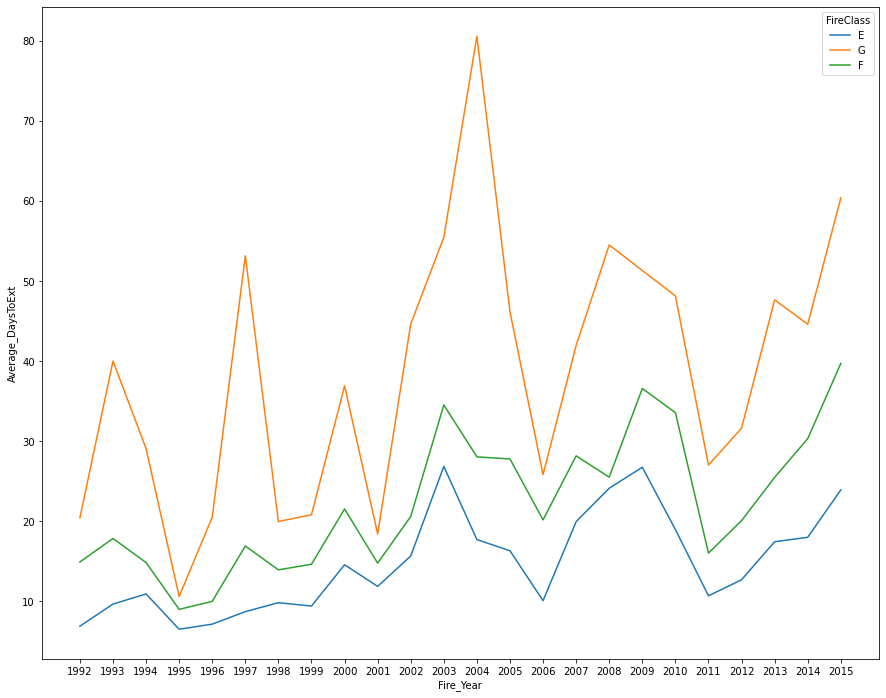

In [34]:
########### DaystoExt of FireClass E,F,G over the years ############
normalized_database_filename = 'lightning_fire_normalized.db'
conn = create_connection(normalized_database_filename)
fire_y = pd.read_sql_query("""
SELECT   FireClass , Fire_Year, Avg(DaysToExt ) as Average_DaysToExt
from 
(SELECT fd2.FireSize, fd2.DaysToExt, fd2.FireClass, fd1.Fire_Year FROM
((SELECT  FireDateID, substr(FireDate, 7, 10) as Fire_Year
From FireDate) fd1
JOIN 
(SELECT * from FireDetails where FireClass IN ("E" , "G" , "F")) fd2
on fd1.FireDateID = fd2.FireDateID) fd3)
group by 1, 2""", conn)

new_df = fire_y.sort_values(by = 'Fire_Year',ascending=True)
plt.figure(figsize=(15, 12))
sns.lineplot(data=new_df, x="Fire_Year", y="Average_DaysToExt", hue="FireClass")
plt.show()